In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from concurrent.futures import ProcessPoolExecutor
import pywt

from cmdstanpy import CmdStanModel
from cmdstanpy import from_csv
import glob
import re

In [2]:
csv_files = glob.glob('stan_output/sinusoid_2025/*20250404104108*.csv') # 
print(csv_files)

fit = from_csv(csv_files)

df_draws = fit.draws_pd()
lp = df_draws["lp__"]  # log posterior column
imax = np.argmax(lp)  # index of sample with highest lp__
best_draw = df_draws.iloc[imax]



def best_draw_to_dict(row):
    result = {}
    for col in row.index:
        # attempt to match something like "paramName[123]"
        m = re.match(r"(.*)\[(\d+)\]$", col)
        if m:
            base_name = m.group(1)
            idx = int(m.group(2))  # 1-based index from Stan
            val = row[col]

            if base_name not in result:
                result[base_name] = {}
            result[base_name][idx] = val
        else:
            result[col] = row[col]

    for k, v in list(result.items()):
        if isinstance(v, dict):
            max_idx = max(v.keys())
            arr = np.empty(max_idx, dtype=float)
            for i in range(1, max_idx + 1):
                arr[i - 1] = v[i]
            result[k] = arr
    return result

best_draw_dict = best_draw_to_dict(best_draw)

['stan_output/sinusoid_2025/sirs_sinusoid_dt-20250404104108_3.csv', 'stan_output/sinusoid_2025/sirs_sinusoid_dt-20250404104108_2.csv', 'stan_output/sinusoid_2025/sirs_sinusoid_dt-20250404104108_4.csv', 'stan_output/sinusoid_2025/sirs_sinusoid_dt-20250404104108_1.csv']


In [3]:
# Define the model itself

# Define a structured array type for parameters
param_dtype = np.dtype([
    ('beta0', np.float64),
    ('beta_amp', np.float64),
    ('freq', np.float64),
    ('phase', np.float64),
    ('gamma', np.float64),
    ('waning_rate', np.float64),
    ('birth_rate', np.float64),
    ('death_rate', np.float64),
    ('noise_level', np.float64)
])

@njit
def run_simulation(t, params, S0, I0, strobe=7):
    
    S = np.zeros(len(t))
    I = np.zeros(len(t))
    R = np.zeros(len(t))
    S[0], I[0], R[0] = S0, I0, 1 - S0 - I0

    dt = t[1]-t[0]
    
    gamma = params.gamma
    mu = params.birth_rate
    delta = params.waning_rate
    noise_level = params.noise_level

    if noise_level > 0:
        alpha = dt/noise_level**2
        beta = noise_level**2
        k_shape = alpha
        theta_scale = beta
    
    for i in range(1,len(t)):
        beta = params.beta0 * (1 + params.beta_amp * np.sin(2 * np.pi * params.freq * t[i] + params.phase))
        if noise_level > 0:
            DeltaGamma_loc = np.random.gamma(k_shape, theta_scale)
            noise = DeltaGamma_loc/dt
        else:
            noise = 1.0
        beta = beta * noise
        foi = beta * I[i-1]
        Sout = (1 - np.exp(-(foi + mu)*dt)) * S[i - 1]
        StoI = foi / (foi + mu) * Sout
        Iout = (1 - np.exp(-(gamma + mu)*dt)) * I[i - 1]
        ItoR = gamma / (gamma + mu) * Iout
        Rout = (1 - np.exp(-(delta + mu)*dt)) * R[i - 1]
        RtoS = Rout * delta/(delta + mu);
        #RtoS = 0
        S[i] = S[i - 1] - Sout + mu*dt + RtoS
        I[i] = I[i - 1] + StoI - Iout
        R[i] = R[i - 1] + ItoR - Rout
    
    return t[::strobe], I[::strobe], S[::strobe]

def compute_SIR(t, params, initial_condition, strobe=7):
    (S0, I0) = initial_condition
    t_out, I, S = run_simulation(t, params, S0, I0, strobe=strobe)
    return I, S

In [4]:
# Simulation setup
n_years = 1100

time_steps_per = 4

nth = time_steps_per
t = np.linspace(0, 52 * n_years, 52 * n_years * time_steps_per) 


params = np.zeros(1, dtype=param_dtype)[0]
params['beta_amp'] =best_draw_dict['dbeta']
params['freq'] = 1/52
params['phase'] = best_draw_dict['betaphase']
params['gamma'] = 1/2.5
params['beta0'] = best_draw_dict['beta0']
params['waning_rate'] = best_draw_dict['delta']
params['birth_rate'] = 1/(80*52)
params['death_rate'] = 1/(80*52)
params['noise_level'] = 0.0

# Define initial conditions
IC_steps = 40
#IC_steps = 100
initial_conditions = [
    (S0, I0) for S0 in np.linspace(0, 1, IC_steps)  # Vary S0
    for I0 in np.logspace(-8, -2, IC_steps)              # Vary I0
    #(S0, I0) for S0 in np.linspace(0.5, 0.6, IC_steps)  # Vary S0
    #for I0 in np.logspace(-4, -2, IC_steps)              # Vary I0
    if S0 + I0 <= 1
]

In [5]:
params["noise_level"] = 0.15
I_o, S_o = compute_SIR(t, params, initial_conditions[0], strobe=time_steps_per)
t_nth = t[::time_steps_per] 

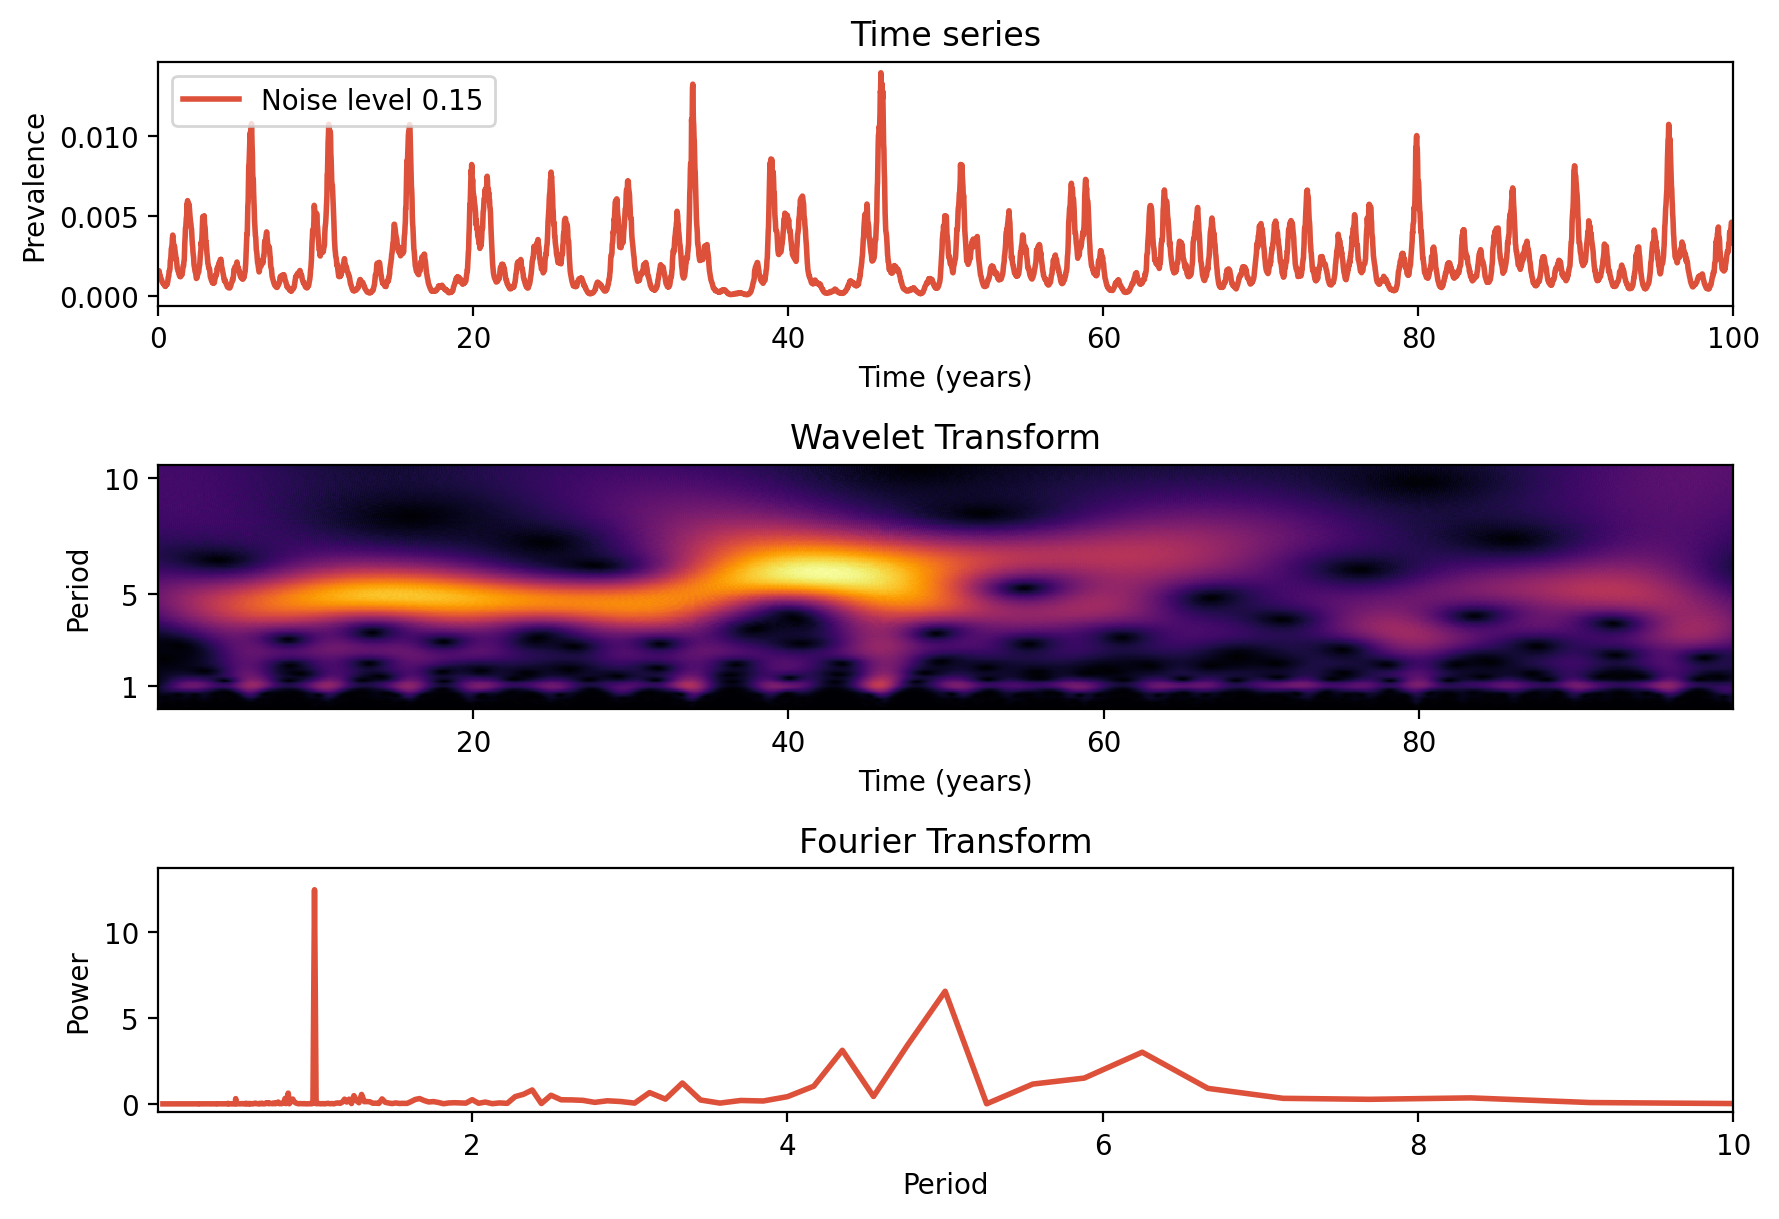

In [6]:
tyrs = 1000
time = t_nth[t_nth > tyrs*52]/52-tyrs
chirp = I_o[t_nth > tyrs*52]


eps_freq = 0.0000001


# perform CWT
wavelet = "cmor1.5-1.0"

widths = np.linspace(1, 550, num=200)

sampling_period = np.diff(time).mean()
cwtmatr, freqs = pywt.cwt(chirp, widths, wavelet, sampling_period=sampling_period)
cwtmatr = np.abs(cwtmatr[:-1, :-1])

fig, axs = plt.subplots(3, 1, figsize=(9, 6.2), dpi=200)
pcm = axs[1].pcolormesh(time, 1/(freqs+eps_freq), cwtmatr, cmap='inferno')
#axs[0].set_yscale("log")
axs[1].set_xlabel("Time (years)")
axs[1].set_ylabel("Period")
axs[1].set_title("Wavelet Transform")
axs[1].set_yticks([1,5, 10])
#fig.colorbar(pcm, ax=axs[0])

# plot fourier transform for comparison
from numpy.fft import rfft, rfftfreq

yf = rfft(chirp)
xf = rfftfreq(len(chirp), sampling_period)
#plt.semilogx(xf, np.abs(yf))
y_plot = np.abs(yf)**2
axs[2].plot(1/(xf+eps_freq), y_plot, color=plt.cm.inferno(0.6), linewidth=2)
axs[2].set_xlim([0.01, 10])
axs[2].set_ylim([-0.5, 1.1*np.max(y_plot[2:])])
axs[2].set_xlabel("Period")
axs[2].set_ylabel("Power")
axs[2].set_title("Fourier Transform")


#plt.xlim([0.01, 10])
#axs[2].set_ylim([0, 1.1*np.max(np.abs(yf[2:]))])
axs[0].set_xlabel("Time (years)")
axs[0].set_title("Time series")
axs[0].set_ylabel("Prevalence")
axs[0].set_xlim([0, 100])
axs[0].plot(time, chirp, color=plt.cm.inferno(0.6), linewidth=2, label=f"Noise level {params["noise_level"]}")
axs[0].legend(loc="upper left")


plt.tight_layout()

